In [1]:
import importlib
import sys
from urllib.request import urlretrieve


# python libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as patches

import pydrake.all

# pydrake imports
from pydrake.common.containers import namedview
from pydrake.systems.scalar_conversion import TemplateSystem
from pydrake.all import (Variable, SymbolicVectorSystem, VectorSystem, DiagramBuilder,
                         LogOutput, Simulator, ConstantVectorSource,
                         MathematicalProgram, Solve, SnoptSolver, PiecewisePolynomial, eq, cos, sin, 
                         DirectTranscription, DirectCollocation)
from pydrake.systems.framework import (BasicVector, BasicVector_, LeafSystem_,
                                       LeafSystem)
import pydrake.symbolic as sym

from lyapunov_control import *
from trajopt_control import *

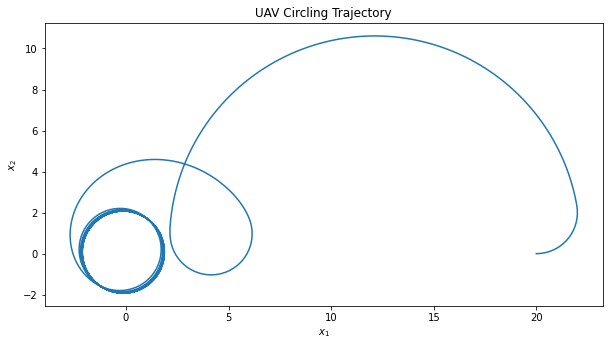

In [2]:
x0 = np.array([20, 0, 0])
xf = np.array([0, 0, 0])

lyapunov_simulation(x0, xf)

(401, 3)


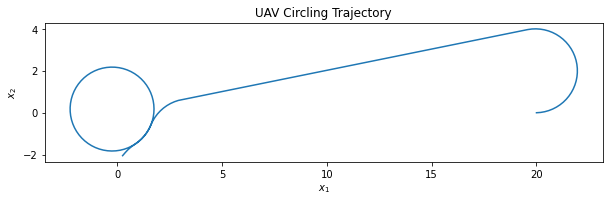

In [3]:
x_opt, u_opt = trajopt_simulation(x0, xf)